## Multi-modal data

Generate synthetic data such that there are regions of the $x$-axis that map to multiple y-values: 

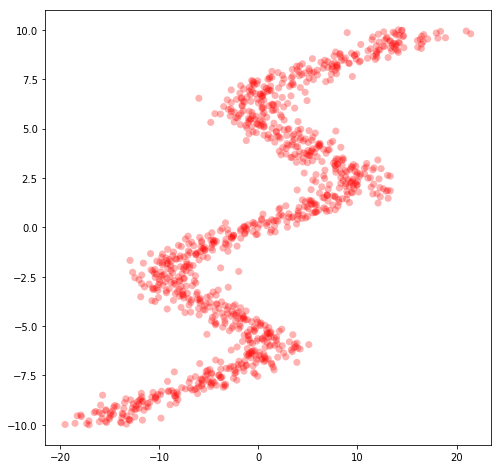

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

number_training_examples = 1000
y = np.linspace(-10, 10, number_training_examples)
x = 7 * np.sin(y * 0.75) + y + np.random.normal(loc=0, scale=2, size=number_training_examples)
x = x.reshape(-1, 1)
y = y.reshape(-1, 1)

plt.figure(figsize=(8, 8))
_ = plt.scatter(x, y, s=50, facecolors='r', edgecolors='none', alpha=0.3)

## Mixture-network model
Following [Bishop](http://publications.aston.ac.uk/373/1/NCRG_94_004.pdf), we create a neural network that, when given a single value of $x$, outputs `number_mixture_components` tuples that together parametrize a mixture of elementary distributions: 

In [3]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras import regularizers

x_tensor = Input(shape=(1,))
hidden = Dense(20, activation=tf.nn.tanh, kernel_regularizer=regularizers.l2(0.01))(x_tensor)
number_mixture_components = 10
priors = Dense(number_mixture_components, activation=tf.nn.softmax)(hidden)
means = Dense(number_mixture_components, activation=None)(hidden)
stds = Dense(number_mixture_components, activation=tf.nn.softplus)(hidden)

import tensorflow_probability as tfp
tfd = tfp.distributions

# https://en.wikipedia.org/wiki/Mixture_distribution
# https://en.wikipedia.org/wiki/Compound_probability_distribution
mixture_distribution = tfd.MixtureSameFamily(
    mixture_distribution=tfd.Categorical(probs=priors),
    components_distribution=tfd.Normal(loc=means, scale=stds))

Instructions for updating:
Colocations handled automatically by placer.

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



Use the so-computed probability distribution of $y$ to compute the loss function:

In [12]:
x_tensor

<tf.Tensor 'input_1:0' shape=(?, 1) dtype=float32>

In [13]:
y_tensor

<tf.Tensor 'Placeholder:0' shape=(?, 1) dtype=float32>

In [14]:
mixture_distribution

<tfp.distributions.MixtureSameFamily 'MixtureSameFamily/' batch_shape=(?,) event_shape=() dtype=float32>

In [15]:
mixture_distribution.log_prob(y)

<tf.Tensor 'MixtureSameFamily/log_prob_6/ReduceLogSumExp/Add:0' shape=(1000, ?) dtype=float32>

In [16]:
mixture_distribution.log_prob(tf.reshape(y_tensor, [-1]))

<tf.Tensor 'MixtureSameFamily/log_prob_7/ReduceLogSumExp/Add:0' shape=(?,) dtype=float32>

In [4]:
y_tensor = tf.placeholder(tf.float32, shape=[None, 1])
loss = -tf.reduce_sum(mixture_distribution.log_prob(tf.reshape(y_tensor, [-1])))

Notice that we flattened `y_tensor` before passing it off to `mixture_distribution.log_prob()`. Here's why: 

In [5]:
with tf.Session() as debug_session: 
    debug_session.run(tf.global_variables_initializer())
    print('mixture_distribution.log_prob(y_tensor) looks like this for 3 training examples:')
    print(debug_session.run(mixture_distribution.log_prob([[1], [2], [3]]), 
                           feed_dict={x_tensor: [[1], [2], [3]]}))
    print('the above leads to inappropriately summing over all elements in a 3x3 matrix in tf.reduce_sum(), which is NOT the log likelihood of the data')
    print('')
    print('mixture_distribution.log_prob(tf.reshape(y_tensor, [-1])) looks like this for 3 training examples:')
    print(debug_session.run(mixture_distribution.log_prob([1, 2, 3]), 
                           feed_dict={x_tensor: [[1], [2], [3]]}))
    print('the above leads to the expected sum of 3 numbers in tf.reduce_sum(), which IS the correct log likelihood of the data')

mixture_distribution.log_prob(y_tensor) looks like this for 3 training examples:
[[-1.459529  -1.4644864 -1.5036528]
 [-3.333836  -2.5794678 -2.3015933]
 [-6.244255  -4.5480766 -3.8875437]]
the above leads to inappropriately summing over all elements in a 3x3 matrix in tf.reduce_sum(), which is NOT the log likelihood of the data

mixture_distribution.log_prob(tf.reshape(y_tensor, [-1])) looks like this for 3 training examples:
[-1.459529  -2.5794678 -3.8875437]
the above leads to the expected sum of 3 numbers in tf.reduce_sum(), which IS the correct log likelihood of the data


For more on this, see: 
* "Broadcasting, aka Why Is This So Confusing?" at: 
https://github.com/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/TensorFlow_Distributions_Tutorial.ipynb
* the graphical depiction of broadcasting rules at: 
https://docs.scipy.org/doc/numpy/user/basics.broadcasting.html


Complete the specification of the tensorflow graph: 

In [5]:
train_ops = tf.train.AdamOptimizer().minimize(loss)

## Training

In [6]:
with tf.Session() as session:
    session.run(tf.global_variables_initializer())
    for epoch in range(10000):
        _, loss_ = session.run([train_ops, loss], feed_dict={x_tensor: x, y_tensor: y})
        if (epoch + 1) % 1000 == 0:
            print(str(epoch + 1) + " : " + str(loss_))

    x_test = np.linspace(-20, 20, 500).reshape((-1, 1))
    y_test_predicted = session.run(mixture_distribution.sample(), feed_dict={x_tensor: x_test})

    priors_predicted, means_predicted, stds_predicted = session.run([priors, means, stds], feed_dict={x_tensor: x})    

1000 : 2497.7346
2000 : 2196.6628
3000 : 1918.8713
4000 : 1830.4155
5000 : 1772.9672
6000 : 1708.9885
7000 : 1673.46
8000 : 1664.2578
9000 : 1654.2477
10000 : 1652.1619


Let's see how samples from the model compare with the original data: 

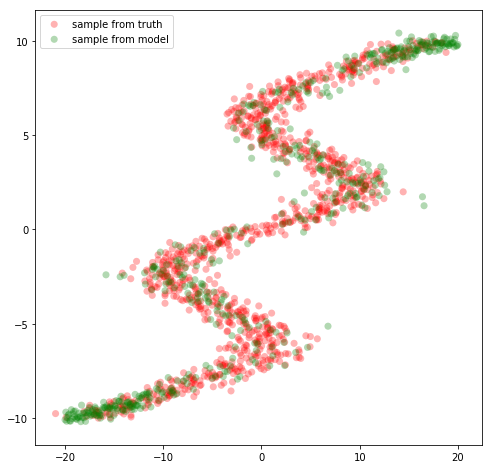

In [7]:
plt.figure(figsize=(8, 8))
plt.scatter(x, y, s=50, facecolors='r', edgecolors='none', alpha=0.3, label='sample from truth')
plt.scatter(x_test, y_test_predicted, s=50, facecolors='g', edgecolors='none', alpha=0.3, label='sample from model')
_ = plt.legend()

Let's compare the predicted, weighted means of each of the mixture components with the original data: 

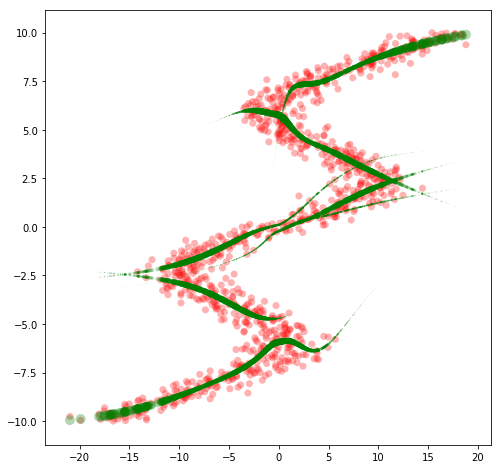

In [8]:
plt.figure(figsize=(8, 8))
plt.scatter(x, y, s=50, facecolors='r', edgecolors='none', alpha=0.3)
for mixture_component in range(number_mixture_components): 
    _ = plt.scatter(x, means_predicted[:, mixture_component], s=100*priors_predicted[:, mixture_component], facecolors='g', edgecolors='none', alpha=0.3)
